<img src="./logo_UTN.svg" align="right" width="150" /> 
#### Teoría de Circuitos II

# Uso de filtros digitales para el preprocesamiento del electrocardiograma
#### Dr. Ing. Mariano Llamedo Soria
Grupo de Investigación en Bioingeniería (GIBIO)



<img src="./Recording-ECG.jpg" align="right" width="150" style="border:10px solid white" /> 


El electrocardiograma (ECG) es una señal eléctrica medida en las extremidades y sobre la superficie del torso de . Debido a que es una técnica no invasiva y su costo no es elevado, es ampliamente utilizada en la clínica médica. Habitualmente se toman entre una y doce señales electrocardiográficas dependiendo de la patología bajo análisis. El ECG es el potencial eléctrico medido en un electrodo colocado sobre la piel, generado por el dipolo eléctrico de cada célula miocárdica al depolarizarse y contraerse.


<img src="./ergo_iss.jpg" align="left" width="350" style="border:10px solid white" /> 


La señal de ECG también es afectada por los campos eléctricos generados por todas las otras fuentes biológicas del organismo bajo estudio (ruido muscular), como también por otros factores como el movimiento de los electrodos sobre la piel y el acople de la línea eléctrica (50/60 Hz) entre otros. Una de las primeras tareas previas al análisis del ECG es el filtrado de interferencias. En el siguiente ejemplo, procederemos al filtrado de un ECG registrado durante una prueba de esfuerzo o ergometría. En dichos registros, las interferencias musculares son muy exageradas dado al esfuerzo físico al que es sometido el paciente.


Para tal fin, se procede a filtrar la señal de ECG con diferentes filtros IIR y FIR, como los estudiados en la asignatura, para evaluar su desempeño de forma cualitativa.

    

En principio procedemos a diseñar los filtros mediante el siguiente script.

In [3]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio

fig_sz_x = 14
fig_sz_y = 13
fig_dpi = 80 # dpi

fig_font_family = 'Ubuntu'
fig_font_size = 16

In [4]:
#Diseño de los filtros digitales

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten(1)
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
nyq_frec = fs / 2


# filter design
ripple = 0.5 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 15.0 #Hz
ws2 = 35.0 #Hz

frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)


bp_sos_butter = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=0.5, gstop=40., analog=False, ftype='butter', output='sos')
bp_sos_cheby = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=0.5, gstop=40., analog=False, ftype='cheby1', output='sos')
bp_sos_cauer = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=0.5, gstop=40., analog=False, ftype='ellip', output='sos')

cant_coef = 501

#num_firls = sig.firls(cant_coef, frecs, gains, fs=fs)
#num_remez = sig.remez(cant_coef, frecs, gains[::2], fs=fs)
num_win =   sig.firwin2(cant_coef, frecs, gains , window='blackmanharris' )

den = 1.0


Una vez diseñados los filtros procedemos a analizarlos

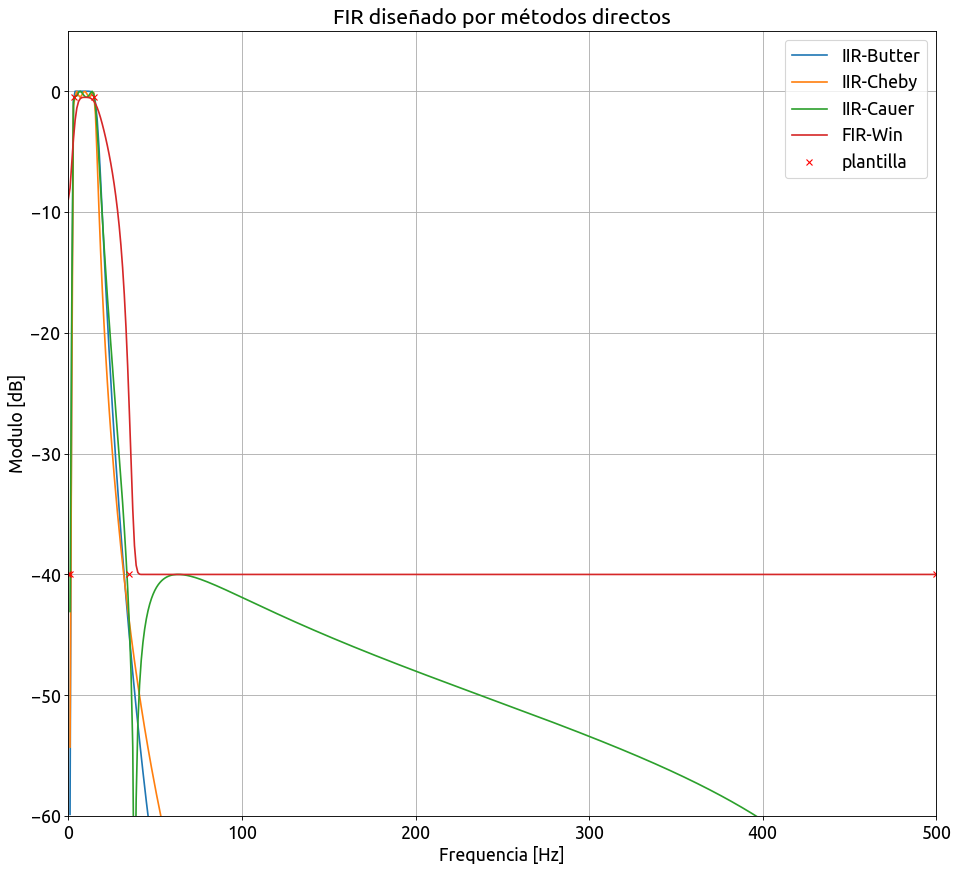

In [5]:

plt.rcParams.update({'font.size':fig_font_size})
plt.rcParams.update({'font.family':fig_font_family})

w, h_butter = sig.sosfreqz(bp_sos_butter)
_, h_cheby = sig.sosfreqz(bp_sos_cheby)
_, h_cauer = sig.sosfreqz(bp_sos_cauer)
#_, hh_firls = sig.freqz(num_firls, den)
#_, hh_remez = sig.freqz(num_remez, den)
_, hh_win = sig.freqz(num_win, den)

w = w / np.pi * nyq_frec


plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')

plt.plot(w, 20*np.log10(np.abs(h_butter)), label='IIR-Butter' )
plt.plot(w, 20*np.log10(np.abs(h_cheby)), label='IIR-Cheby' )
plt.plot(w, 20*np.log10(np.abs(h_cauer)), label='IIR-Cauer' )
#plt.plot(w, 20 * np.log10(abs(hh_firls)), label='FIR-ls')
#plt.plot(w, 20 * np.log10(abs(hh_remez)), label='FIR-remez')
plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win')
plt.plot(frecs * nyq_frec, 20*np.log10(gains), 'rx', label='plantilla' )

plt.title('FIR diseñado por métodos directos')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.axis([0, nyq_frec, -60, 5 ]);

plt.grid()

axes_hdl = plt.gca()
axes_hdl.legend()

plt.show()




Finalmente los utilizaremos mediante las funciones que implementan el filtrado bidireccional (*scipy.signal.filtfilt*).

El filtrado bidireccional es una técnica sumamente conveniente al momento de filtrar digitalmente una señal, dado que evita por completo cualquier distorsión de fase. Esto afecta principalmente a los filtros IIR, donde las distorciones pueden ser notorias. Sin embargo, los filtros FIR cuya respuesta al impulso sea simétrica (par o impar) no producen distorción de fase debido a su fase perfectamente lineal. 

En ambos casos, tanto para los IIR como para los FIR, simétricos o no, el resultado es una anulación completa de la respuesta de fase, obteniéndose así un **filtro de fase cero**. 


Recordemos la siguiente propiedad de la transformada de Fourier:
$$ h(n) -> $$

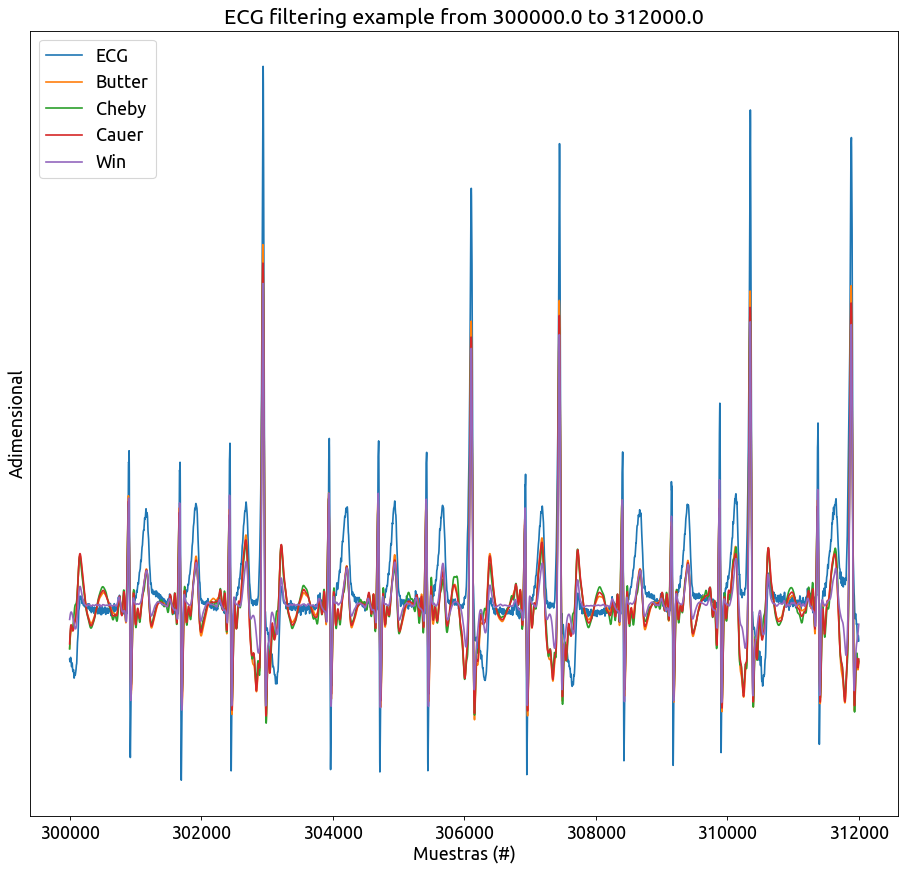

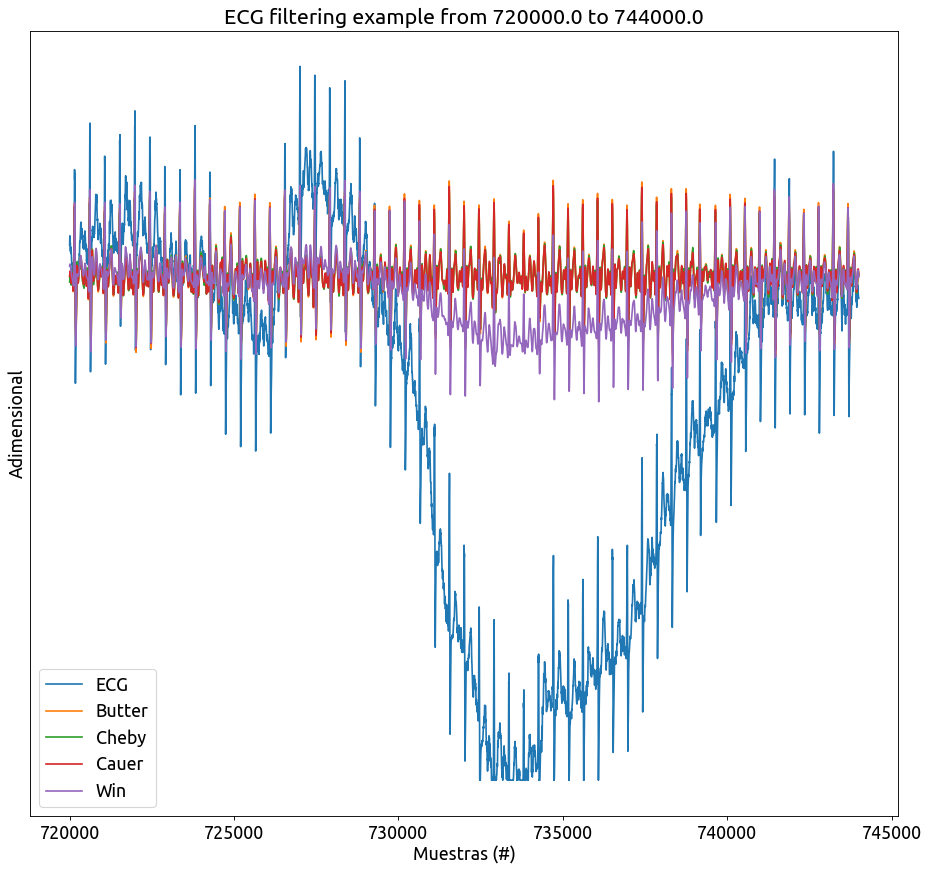

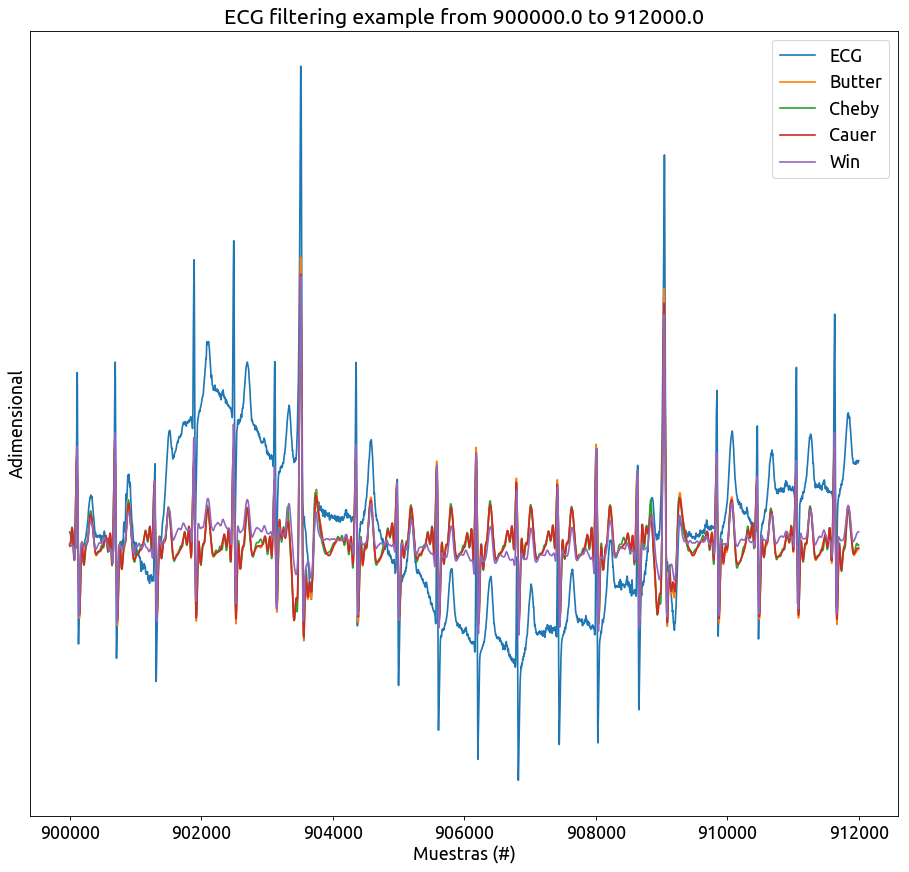

In [6]:
# Procedemos al filtrado
ECG_f_butt = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)
ECG_f_cheb = sig.sosfiltfilt(bp_sos_cheby, ecg_one_lead)
ECG_f_cauer = sig.sosfiltfilt(bp_sos_cauer, ecg_one_lead)

#ECG_f_ls = sig.filtfilt(num_firls, den, ecg_one_lead)
#ECG_f_remez = sig.filtfilt(num_remez, den, ecg_one_lead)
ECG_f_win = sig.filtfilt(num_win, den, ecg_one_lead)

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG')
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_cheb[zoom_region], label='Cheby')
    plt.plot(zoom_region, ECG_f_cauer[zoom_region], label='Cauer')
    #plt.plot(zoom_region, ECG_f_remez[zoom_region], label='Remez')
    #plt.plot(zoom_region, ECG_f_ls[zoom_region], label='LS')
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Al analizar el efecto del filtrado, observamos que la señal original de ECG (en azul) posee contaminación de baja frecuencia en algunas zonas del registro. Dicha contaminación probablemente se deba al aumento de la actividad física durante la prueba de esfuerzo. Como se observa, la mayor parte de las técnicas de filtrados es inocua cuando no hay contaminación de baja frecuencia, y remueve los movimientos de la línea de base correctamente. Sin embargo, algunos filtros, como los FIR diseñados por el método de ventana, no son capaces de eliminar por completo la interferencia a pesar de su elevado orden, como se aprecia en la señal violeta en el segundo panel.

Ahora analizaremos cómo se han comportado los filtros analizando la señal en detalle para algunos latidos específicos. Desde luego nos interesará que la señal de ECG no haya sido alterada en su morfología, debido a que esto podría imposibilitar su uso como método de diagnóstico. 

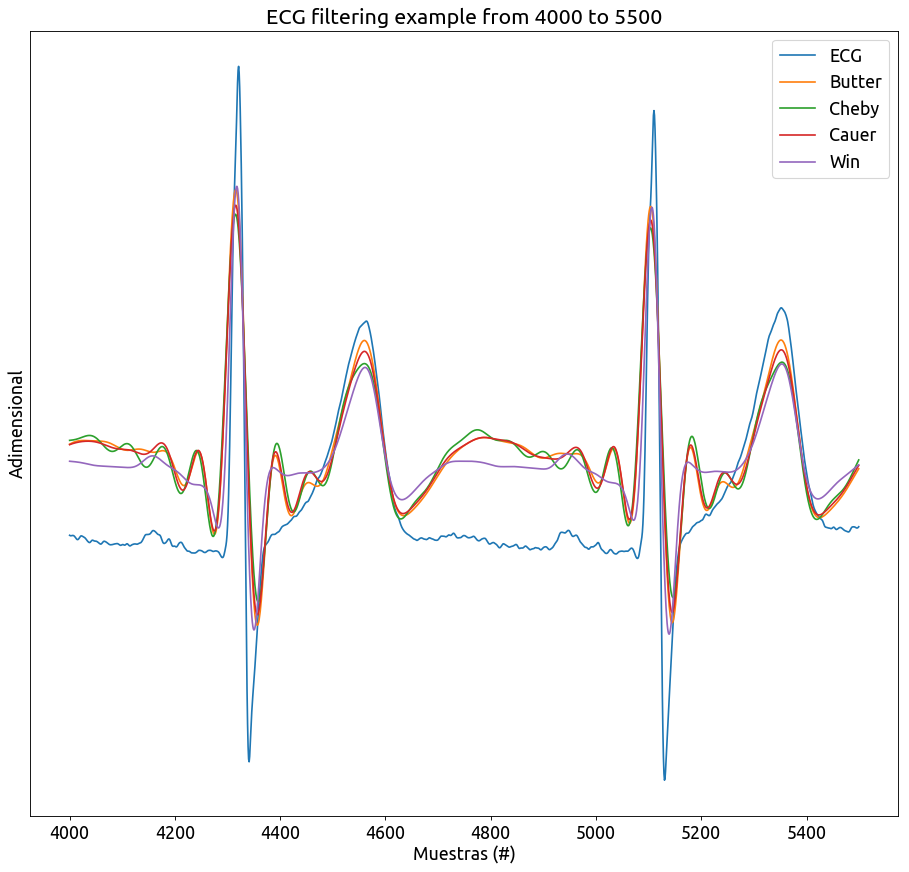

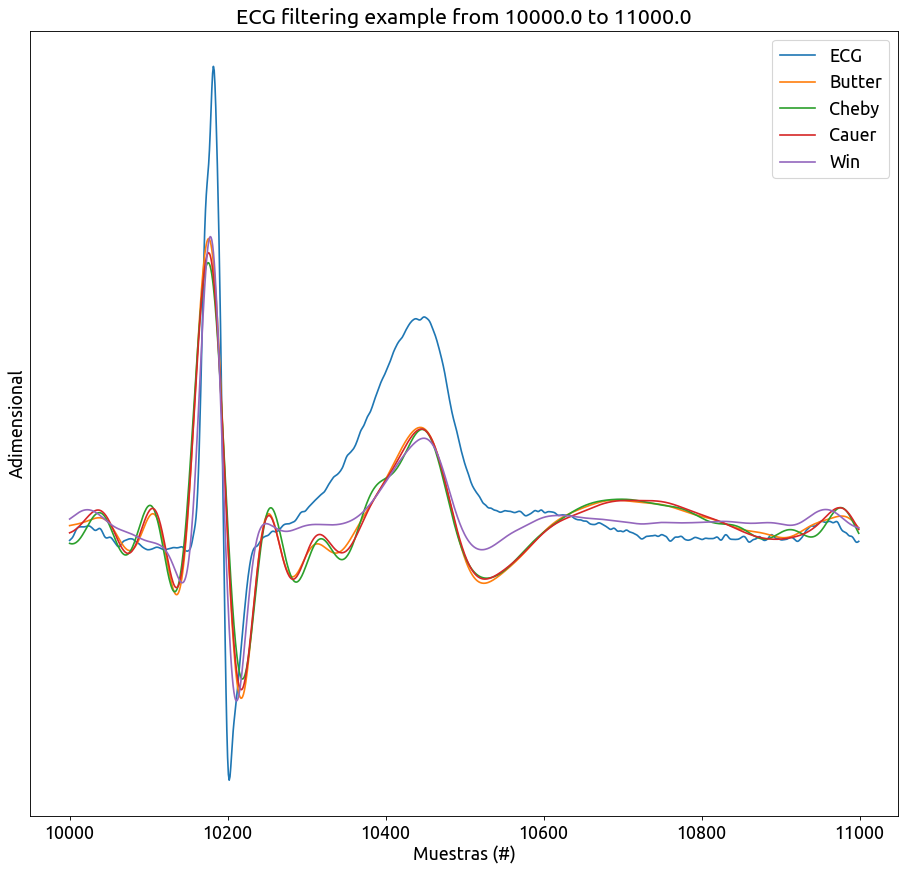

In [7]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG')
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(zoom_region, ECG_f_cheb[zoom_region], label='Cheby')
    plt.plot(zoom_region, ECG_f_cauer[zoom_region], label='Cauer')
    #plt.plot(zoom_region, ECG_f_remez[zoom_region], label='Remez')
    #plt.plot(zoom_region, ECG_f_ls[zoom_region], label='LS')
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.set_yticks(())
    axes_hdl.legend()
            
    plt.show()

Como se observa, la señal de ECG ha sido alterada en su morfología. El complejo de ondas QRS, es decir las primeras deflecciones rápidas de mayor energía relacionadas con la compresión muscular, han sido claramente atenuadas, mientras que la onda T, la segunda onda positiva de mayor duración y relacionada con la relajación muscular, ha sido también atenuada. También se observan otros artefactos ocasionados por el filtrado lineal, como oscilaciones que no estaban presentes en el ECG original. Estas observaciones dan cuenta, que estos filtros no son adecuados para esta tarea y es necesario su rediseño teniendo en cuenta estos aspectos.